In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

## Dead time and QPOs

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


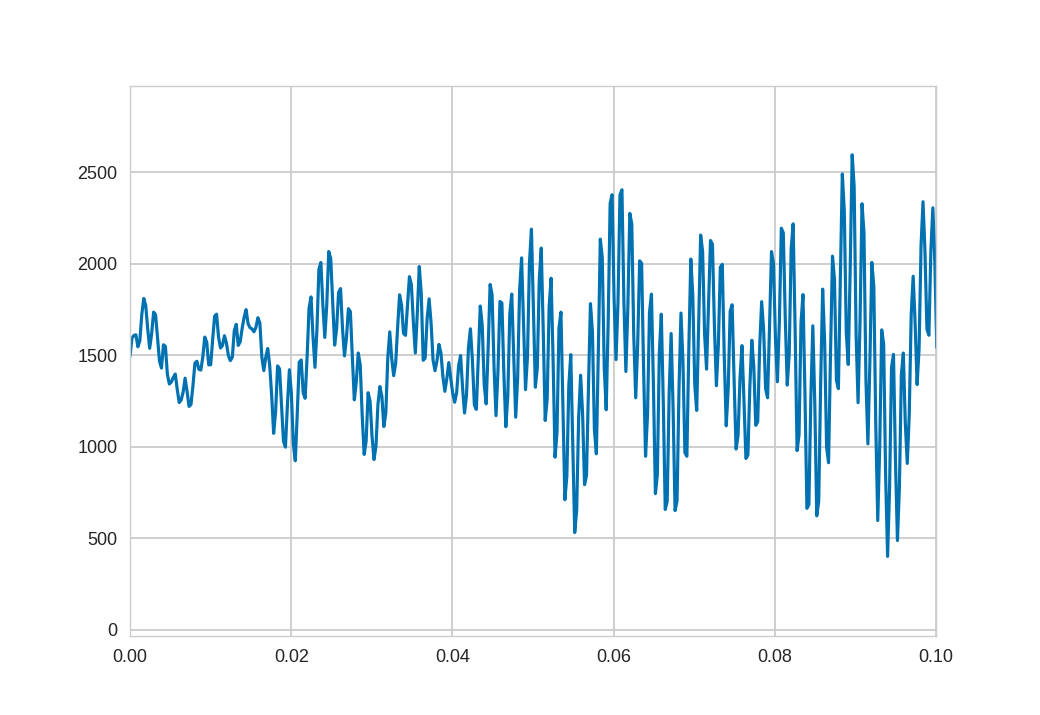

(0, 0.1)

In [2]:
from astropy.modeling.models import Lorentz1D, Const1D
from stingray.events import EventList

tstart = 0
tstop = 1000
dt = 1/4096

time = np.arange(tstart, tstop, dt)
mean_ctrate = 400
rms = 0.25

sim = Simulator(N=len(time), dt=1/4096, rms=0.7, mean=400, red_noise=3)
model = Lorentz1D(x_0=100, fwhm=10, amplitude=100) + \
    Lorentz1D(x_0=800, fwhm=10, amplitude=100) #+ Lorentz1D(x_0=0, fwhm=100, amplitude=100)

sim_lc_clean = sim.simulate(model)
sim_lc_clean.counts *= dt

sim_lc_clean.counts -= (np.min(sim_lc_clean.counts) - 100 * dt)

plt.figure()
plt.plot(sim_lc_clean.time, sim_lc_clean.counts / dt)
plt.xlim([0, 0.1])

In [3]:
events = EventList()
events.simulate_times(sim_lc_clean)
whitenoise_ev_1 = events.time

events.simulate_times(sim_lc_clean)
whitenoise_ev_2 = events.time

sim_lc = copy.copy(sim_lc_clean)
sim_lc.counts = np.random.poisson(sim_lc_clean.counts)

lc1_clean = Lightcurve.make_lightcurve(whitenoise_ev_1, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=1/4096)
lc2_clean = Lightcurve.make_lightcurve(whitenoise_ev_2, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=1/4096)


wn_ev_1_dt = filter_for_deadtime(whitenoise_ev_1, 2.5e-3)
wn_ev_2_dt = filter_for_deadtime(whitenoise_ev_2, 2.5e-3)


In [4]:
lc1 = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(wn_ev_2_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=1/4096)


In [5]:
from fad_correction import *

countrate_ratio = lc1.meanrate / lc2.meanrate
segment_size=512

freqs, pds1_norm, pds2_norm, crosssp_norm, ptot_norm = \
    FAD_power_spectra(lc1, lc2, segment_size)
pds_norm = pds1_norm

pds1_dt = AveragedPowerspectrum(lc1, segment_size=5, norm="frac")


In [5]:
# from scipy.interpolate import interp1d
# from stingray.utils import rebin_data_log
# from hendrics.base import r_in
# good_counts1 = lc1.counts
# good_counts2 = lc2.counts
# fourier1 = scipy.fftpack.fft(good_counts1)
# fourier2 = scipy.fftpack.fft(good_counts2)
# freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

# fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
# fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))

# freqs = freqs[freqs > 0]

# smooth_real = gaussian_filter1d((fourier1 - fourier2).real**2, tstop)
# smooth_fun = interp1d(freqs, smooth_real)

# print(len(lc1), len(lc2), lc1.tseg)
# pds1_dt = AveragedPowerspectrum(lc1, segment_size=5, norm="frac")

# # Use fractional rms normalization
# pds_norm = AveragedPowerspectrum(lc1, segment_size=5, norm='none') 
# pds_norm.power = pds_norm.power / smooth_fun(pds_norm.freq) * 2 
# pds_norm.power = pds_norm.power / pds_norm.n**2 
# pds_norm.power = pds_norm.power * 2 * 5 / lc1.meancounts **2

# pds = AveragedPowerspectrum(sim_lc, segment_size=5, norm='frac')


4096000 4096000 1000.0


In [7]:
pds = AveragedPowerspectrum(sim_lc, segment_size=5, norm='frac')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [8]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, hspace=0, height_ratios=(3, 2))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)


# ax1.plot(cs_dt.freq, pds_dt.power, alpha=0.5, label='Power spectrum, averaged')
ax1.plot(pds1_dt.freq, pds1_dt.power, alpha=0.4, label='PDS 1', drawstyle='steps-mid')
# ax1.plot(cs_dt.freq, pds2_dt.power, alpha=0.5, label='Power spectrum 2')

binx, power, biny_err, nsamples = rebin_data(pds.freq, pds.power - np.median(pds.power), 3)
binx = np.asarray(binx)
ax1.plot(binx, power, alpha=0.6, label='Deadtime-free PDS', zorder=10, drawstyle='steps-mid', 
         lw=2)

binx, power_norm, biny_err, nsamples = rebin_data(pds_norm.freq, pds_norm.power, 3)
binx = np.asarray(binx)
ax1.plot(binx, power_norm - np.median(power_norm), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

ax1.legend(loc=1)
# ax1.set_yscale('log', nonposy='clip')
ax1.set_xlim([10, 1000])
# ax1.set_ylim([1e-4, None])

ax2.plot(binx, power_norm - power - np.median(power_norm) + np.median(power), drawstyle='steps-mid')

ax1.axvline(100, ls='--')
ax2.axvline(100, ls='--')

ax1.axvline(800, ls='--')
ax2.axvline(800, ls='--')


ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('qpos.jpg')

<IPython.core.display.Javascript object>

AttributeError: 'numpy.ndarray' object has no attribute 'freq'

## Slightly different fluxes - let's hurt ourselves

In [7]:
from astropy.modeling.models import Lorentz1D, Const1D
from stingray.events import EventList

tstart = 0
tstop = 1000
dt = 1/4096

time = np.arange(tstart, tstop, dt)
mean_ctrate = 400
rms = 0.25

sim = Simulator(N=len(time), dt=1/4096, rms=0.7, mean=400, red_noise=3)
model = Lorentz1D(x_0=100, fwhm=10, amplitude=100) + \
    Lorentz1D(x_0=800, fwhm=10, amplitude=100) #+ Lorentz1D(x_0=0, fwhm=100, amplitude=100)

sim_lc_clean = sim.simulate(model)
sim_lc_clean.counts *= dt

sim_lc_clean.counts -= (np.min(sim_lc_clean.counts) - 100 * dt)

In [8]:
events = EventList()
events.simulate_times(sim_lc_clean)
whitenoise_ev_1 = events.time

sim_lc_clean_lower = copy.deepcopy(sim_lc_clean)
sim_lc_clean_lower.counts *= 0.95
events.simulate_times(sim_lc_clean_lower)
whitenoise_ev_2 = events.time

sim_lc = copy.copy(sim_lc_clean)
sim_lc.counts = np.random.poisson(sim_lc_clean.counts)

lc1_clean = Lightcurve.make_lightcurve(whitenoise_ev_1, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=1/4096)
lc2_clean = Lightcurve.make_lightcurve(whitenoise_ev_2, 
                                       gti=[[tstart, tstop]], 
                                       tstart=tstart, tseg=tstop - tstart, dt=1/4096)


wn_ev_1_dt = filter_for_deadtime(whitenoise_ev_1, 2.5e-3)
wn_ev_2_dt = filter_for_deadtime(whitenoise_ev_2, 2.5e-3)



In [9]:
lc1 = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(wn_ev_2_dt, gti=[[tstart, tstop]], tstart=tstart, tseg=tstop - tstart, dt=1/4096)



In [10]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from hendrics.base import r_in
good_counts1 = lc1.counts
good_counts2 = lc2.counts
fourier1 = scipy.fftpack.fft(good_counts1)
fourier2 = scipy.fftpack.fft(good_counts2)
freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))

freqs = freqs[freqs > 0]

smooth_real = gaussian_filter1d((fourier1 - fourier2).real**2, tstop)
smooth_fun = interp1d(freqs, smooth_real)

print(len(lc1), len(lc2), lc1.tseg)
pds1_dt = AveragedPowerspectrum(lc1, segment_size=5, norm="frac")

pds_norm = AveragedPowerspectrum(lc1, segment_size=5, norm='none') 
pds_norm.power = pds_norm.power / smooth_fun(pds_norm.freq) * 2 
pds_norm.power = pds_norm.power / pds_norm.n**2 
pds_norm.power = pds_norm.power * 2 * 5 / lc1.meancounts **2

pds = AveragedPowerspectrum(sim_lc, segment_size=5, norm='frac')



4096000 4096000 1000.0


<IPython.core.display.Javascript object>


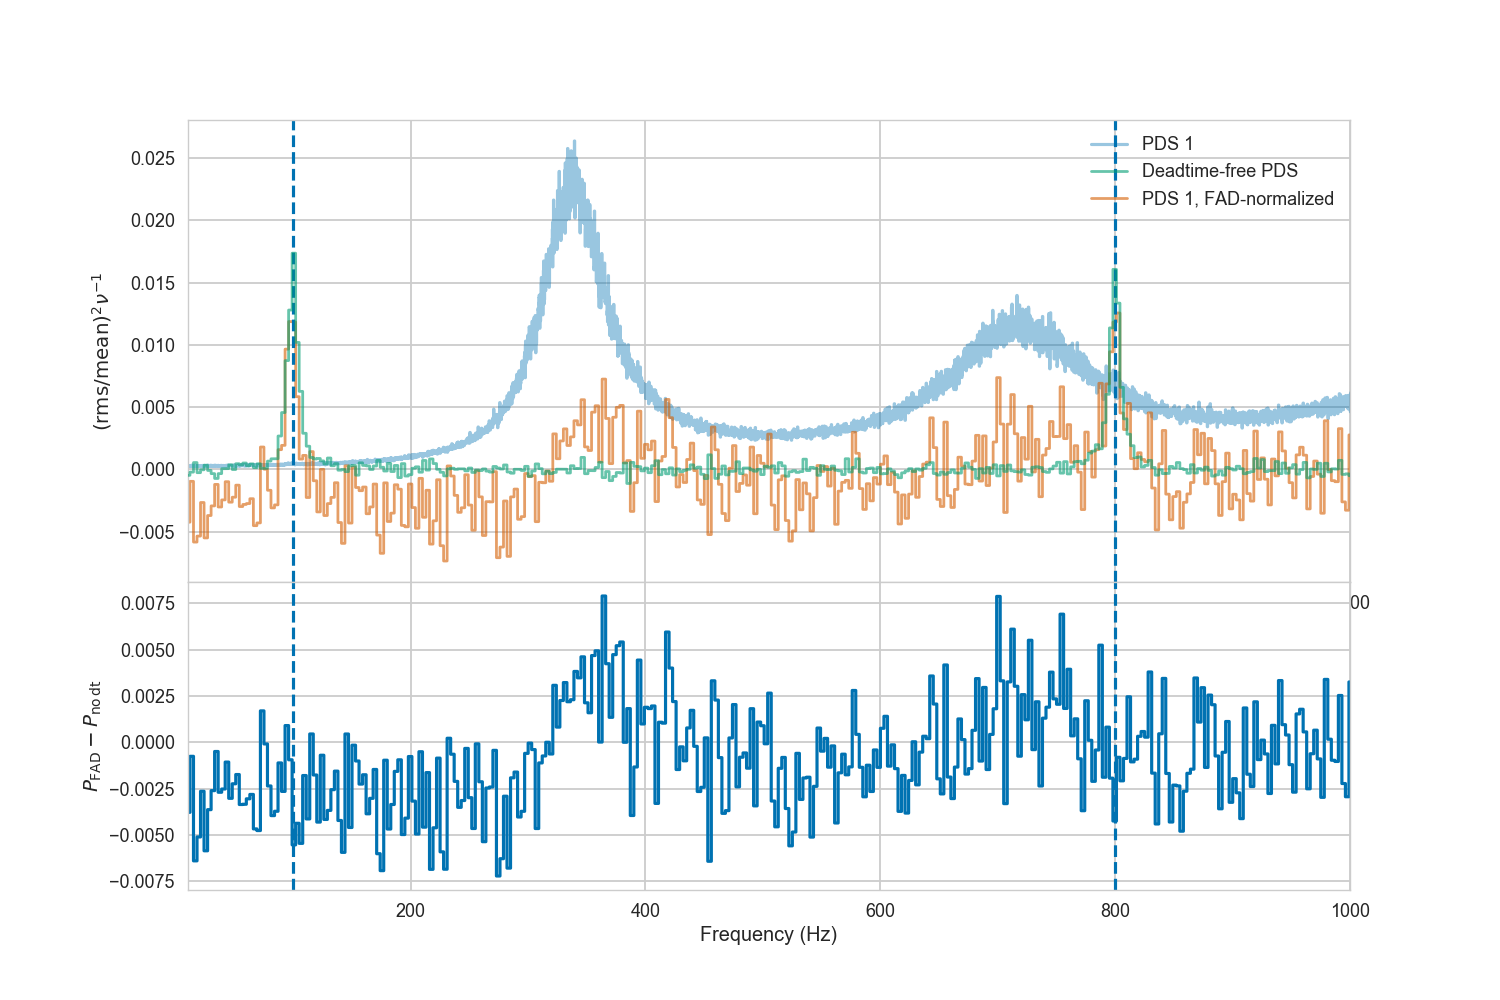

In [11]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, hspace=0, height_ratios=(3, 2))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)


# ax1.plot(cs_dt.freq, pds_dt.power, alpha=0.5, label='Power spectrum, averaged')
ax1.plot(pds1_dt.freq, pds1_dt.power, alpha=0.4, label='PDS 1', drawstyle='steps-mid')
# ax1.plot(cs_dt.freq, pds2_dt.power, alpha=0.5, label='Power spectrum 2')

binx, power, biny_err, nsamples = rebin_data(pds.freq, pds.power - np.median(pds.power), 3)
binx = np.asarray(binx)
ax1.plot(binx, power, alpha=0.6, label='Deadtime-free PDS', zorder=10, drawstyle='steps-mid', 
         lw=2)

binx, power_norm, biny_err, nsamples = rebin_data(pds_norm.freq, pds_norm.power, 3)
binx = np.asarray(binx)
ax1.plot(binx, power_norm - np.median(power_norm), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')

ax1.legend(loc=1)
# ax1.set_yscale('log', nonposy='clip')
ax1.set_xlim([10, 1000])
# ax1.set_ylim([1e-4, None])

ax2.plot(binx, power_norm - power - np.median(power_norm) + np.median(power), drawstyle='steps-mid')

ax1.axvline(100, ls='--')
ax2.axvline(100, ls='--')

ax1.axvline(800, ls='--')
ax2.axvline(800, ls='--')

power_norm_save = power_norm
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('qpos_diffflux.jpg')

Will the simple correction of the light curve work, as in the deadtime-free case?

In [12]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from hendrics.base import r_in, r_det
good_counts1 = lc1.counts
good_counts2 = lc2.counts

mean1 = np.mean(good_counts1)
mean2 = np.mean(good_counts2)
good_counts2 = good_counts2 * mean1 / mean2

fourier1 = scipy.fftpack.fft(good_counts1)
fourier2 = scipy.fftpack.fft(good_counts2)
freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
freqs = freqs[freqs > 0]

smooth_real = gaussian_filter1d((fourier1 - fourier2).real**2, tstop)
smooth_fun = interp1d(freqs, smooth_real)

print(len(lc1), len(lc2), lc1.tseg)
pds1_dt = AveragedPowerspectrum(lc1, segment_size=5, norm="frac")

pds_norm = AveragedPowerspectrum(lc1, segment_size=5, norm='none') 
pds_norm.power = pds_norm.power / smooth_fun(pds_norm.freq) * 2 
pds_norm.power = pds_norm.power / pds_norm.n**2 
pds_norm.power = pds_norm.power * 2 * 5 / lc1.meancounts **2

# if self.norm.lower() == 'leahy':
#     c = unnorm_power.real
#     power = c * 2. / actual_nphots

# elif self.norm.lower() == 'frac':
#     c = unnorm_power.real / np.float(self.n ** 2.)
#     power = c * 2. * tseg / (actual_mean ** 2.0)

pds = AveragedPowerspectrum(sim_lc, segment_size=5, norm='frac')




4096000 4096000 1000.0


<IPython.core.display.Javascript object>


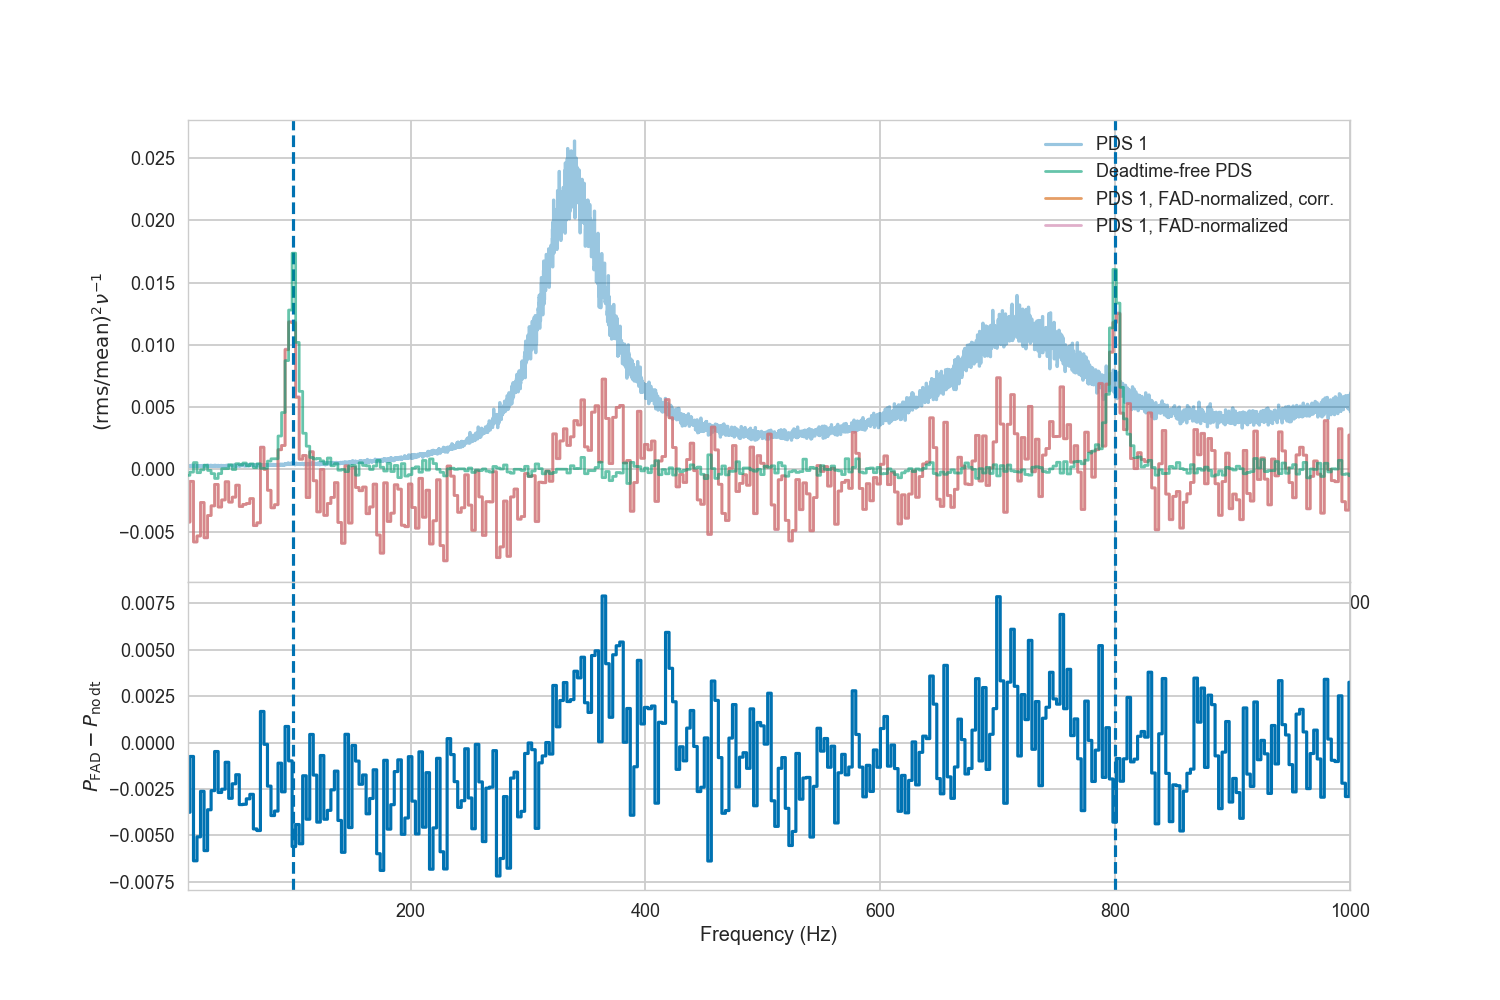

In [13]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, hspace=0, height_ratios=(3, 2))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)


# ax1.plot(cs_dt.freq, pds_dt.power, alpha=0.5, label='Power spectrum, averaged')
ax1.plot(pds1_dt.freq, pds1_dt.power, alpha=0.4, label='PDS 1', drawstyle='steps-mid')
# ax1.plot(cs_dt.freq, pds2_dt.power, alpha=0.5, label='Power spectrum 2')

binx, power, biny_err, nsamples = rebin_data(pds.freq, pds.power - np.median(pds.power), 3)
binx = np.asarray(binx)
ax1.plot(binx, power, alpha=0.6, label='Deadtime-free PDS', zorder=10, drawstyle='steps-mid', 
         lw=2)

binx, power_norm, biny_err, nsamples = rebin_data(pds_norm.freq, pds_norm.power, 3)
binx = np.asarray(binx)
ax1.plot(binx, power_norm - np.median(power_norm), alpha=0.6, label='PDS 1, FAD-normalized, corr.', 
         lw=2, drawstyle='steps-mid')
ax1.plot(binx, power_norm_save - np.median(power_norm_save), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')


ax1.legend(loc=1)
# ax1.set_yscale('log', nonposy='clip')
ax1.set_xlim([10, 1000])
# ax1.set_ylim([1e-4, None])

ax2.plot(binx, power_norm - power - np.median(power_norm) + np.median(power), drawstyle='steps-mid')

ax1.axvline(100, ls='--')
ax2.axvline(100, ls='--')

ax1.axvline(800, ls='--')
ax2.axvline(800, ls='--')


ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('qpos_diffflux_corr.jpg')

No, it won't. Let's try to correct the _incident_ count rate

0.989264158783
[ 1.02413793  1.02447854  1.02515279  1.02615153  1.02745479  1.02903841
  1.03087813  1.03294328  1.03519869  1.03760806  1.04013613  1.04274232
  1.04538997  1.04803635  1.05065209  1.05320131  1.05565557  1.05799195
  1.06017729  1.06219957] [ 1.00512553  1.0051972   1.00533902  1.005549    1.00582281  1.00615528
  1.0065412   1.00697401  1.00744629  1.00795037  1.00847889  1.00902341
  1.00957631  1.01012881  1.01067485  1.01120709  1.01171969  1.01220793
  1.01266502  1.01308849]


<IPython.core.display.Javascript object>


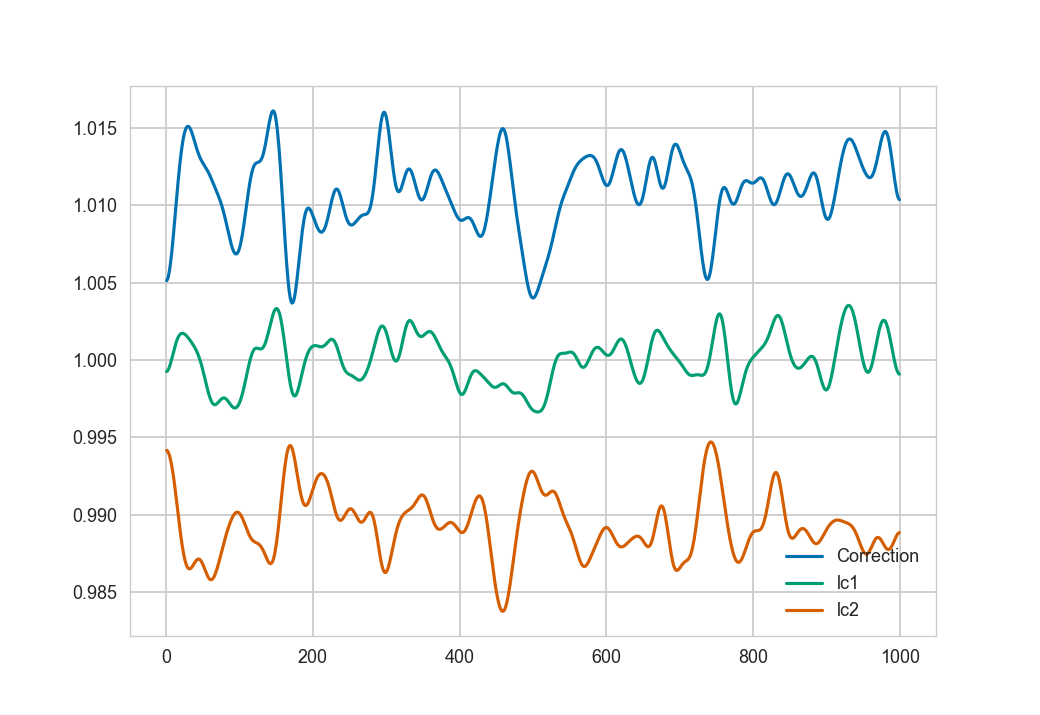

In [14]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from hendrics.base import r_in, r_det
good_counts1 = lc1.counts
good_counts2 = lc2.counts

# Let's extrapolate the _mean_ count rate
lc1_smooth = lc1.rebin(1)
lc2_smooth = lc2.rebin(1)
print(lc2.meanrate / lc1.meanrate)

lc1_smooth.counts = gaussian_filter1d(lc1_smooth.counts, 10)
lc2_smooth.counts = gaussian_filter1d(lc2_smooth.counts, 10)

good_counts1_in = r_in(2.5e-3, lc1_smooth.counts)
good_counts2_in = r_in(2.5e-3, lc2_smooth.counts)
corr = good_counts1_in / good_counts2_in

good_counts2_det = r_det(2.5e-3, good_counts2_in * corr)
ratio = good_counts2_det / lc2_smooth.counts
print(corr[:20], ratio[:20])
corr_fun = interp1d(lc1_smooth.time, ratio, bounds_error=False, fill_value='extrapolate')

fourier1 = scipy.fftpack.fft(good_counts1)
fourier2 = scipy.fftpack.fft(good_counts2 * corr_fun(lc1.time))
freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2 * corr_fun(lc1.time)))
freqs = freqs[freqs > 0]
plt.figure()
plt.plot(lc1_smooth.time, corr_fun(lc1_smooth.time), label='Correction')
plt.plot(lc1_smooth.time, lc1_smooth.counts / np.mean(lc1_smooth.counts), label='lc1')
plt.plot(lc1_smooth.time, lc2_smooth.counts / np.mean(lc1_smooth.counts), label='lc2')

plt.legend()

# plt.plot(lc1.time, corr_fun(lc1.time) * lc1.dt)
# plt.plot(lc1.time, good_counts2 * corr_fun(lc1.time))

# plt.xlim([0, 10])

In [15]:
smooth_real = gaussian_filter1d((fourier1 - fourier2).real**2, tstop)
smooth_fun = interp1d(freqs, smooth_real)

print(len(lc1), len(lc2), lc1.tseg)
pds1_dt = AveragedPowerspectrum(lc1, segment_size=5, norm="frac")

pds_norm = AveragedPowerspectrum(lc1, segment_size=5, norm='none') 
pds_norm.power = pds_norm.power / smooth_fun(pds_norm.freq) * 2 
pds_norm.power = pds_norm.power / pds_norm.n**2 
pds_norm.power = pds_norm.power * 2 * 5 / lc1.meancounts **2

# if self.norm.lower() == 'leahy':
#     c = unnorm_power.real
#     power = c * 2. / actual_nphots

# elif self.norm.lower() == 'frac':
#     c = unnorm_power.real / np.float(self.n ** 2.)
#     power = c * 2. * tseg / (actual_mean ** 2.0)

pds = AveragedPowerspectrum(sim_lc, segment_size=5, norm='frac')

4096000 4096000 1000.0


<IPython.core.display.Javascript object>


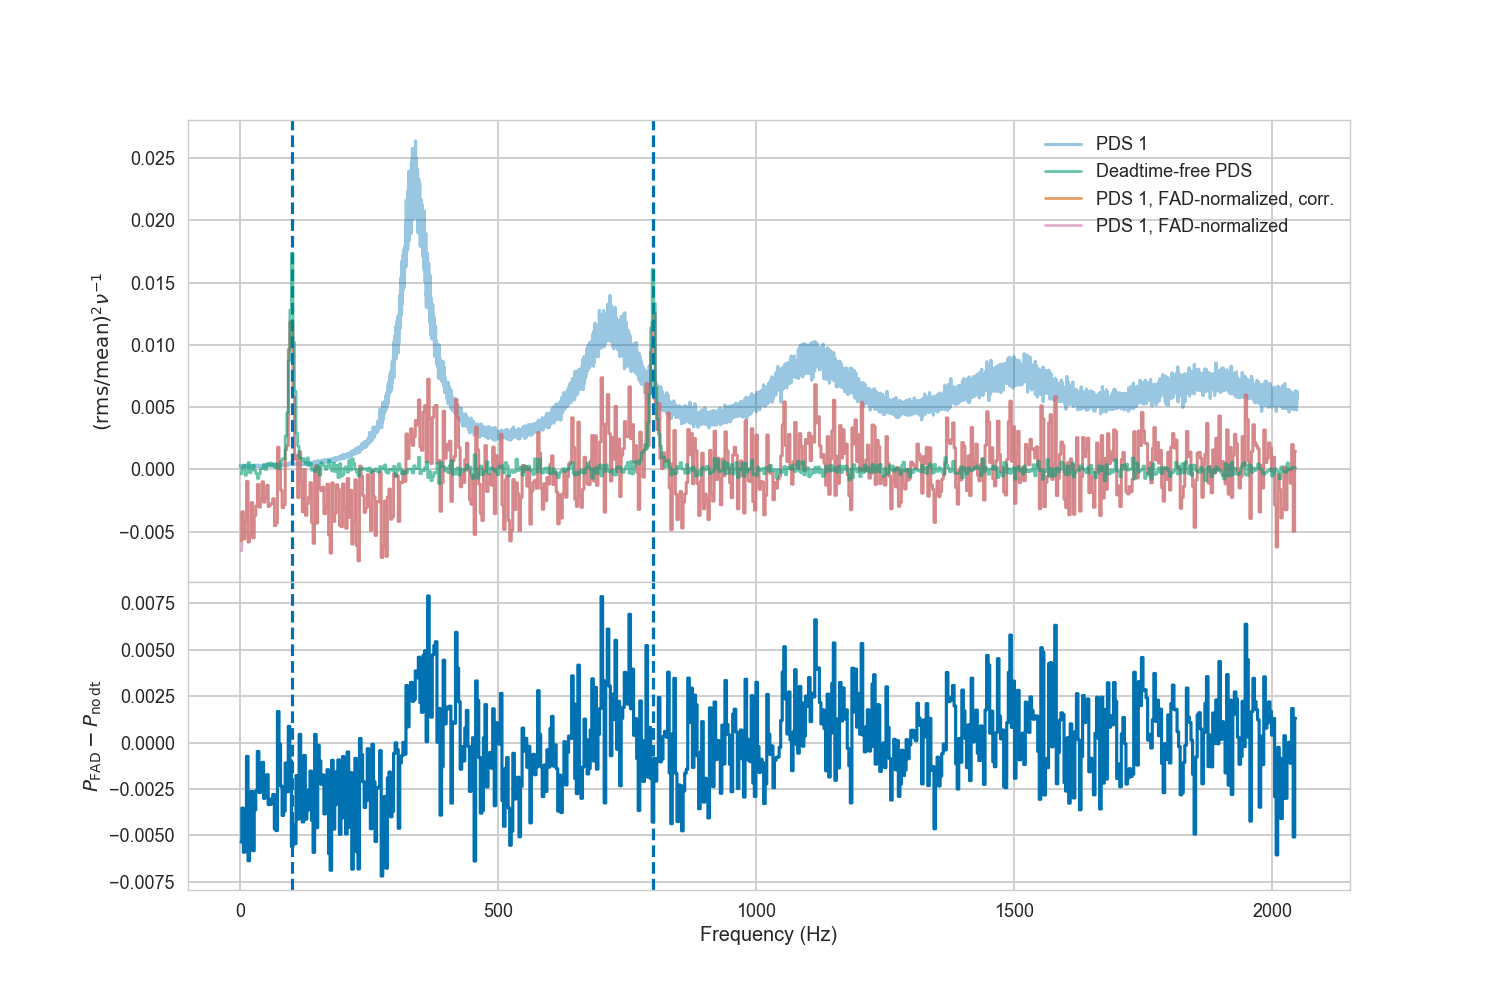

In [16]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 1, hspace=0, height_ratios=(3, 2))

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)


# ax1.plot(cs_dt.freq, pds_dt.power, alpha=0.5, label='Power spectrum, averaged')
ax1.plot(pds1_dt.freq, pds1_dt.power, alpha=0.4, label='PDS 1', drawstyle='steps-mid')
# ax1.plot(cs_dt.freq, pds2_dt.power, alpha=0.5, label='Power spectrum 2')

binx, power, biny_err, nsamples = rebin_data(pds.freq, pds.power - np.median(pds.power), 3)
binx = np.asarray(binx)
ax1.plot(binx, power, alpha=0.6, label='Deadtime-free PDS', zorder=10, drawstyle='steps-mid', 
         lw=2)

binx, power_norm, biny_err, nsamples = rebin_data(pds_norm.freq, pds_norm.power, 3)
binx = np.asarray(binx)
ax1.plot(binx, power_norm - np.median(power_norm), alpha=0.6, label='PDS 1, FAD-normalized, corr.', 
         lw=2, drawstyle='steps-mid')
ax1.plot(binx, power_norm_save - np.median(power_norm_save), alpha=0.6, label='PDS 1, FAD-normalized', 
         lw=2, drawstyle='steps-mid')
# print(power_norm_save - power_norm)
ax1.legend(loc=1)
# ax1.set_yscale('log', nonposy='clip')
# ax1.set_xlim([10, 1000])
# ax1.set_ylim([1e-4, None])

ax2.plot(binx, power_norm - power - np.median(power_norm) + np.median(power), drawstyle='steps-mid')

ax1.axvline(100, ls='--')
ax2.axvline(100, ls='--')

ax1.axvline(800, ls='--')
ax2.axvline(800, ls='--')


ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel(r'${(\rm rms/mean)}^2 \nu^{-1}$')
ax2.set_ylabel(r'$P_{\rm FAD} - P_{\rm no\,dt}$')
plt.savefig('qpos_diffflux_corr.jpg')
ax1.legend()

Again, no. The mean count rate might work for very slow variability, but not if we want to go to 100 Hz. 

We are not going to correct the different spectral shapes for timescales much shorter than those at which we calculate the count rates. And calculating the countrates in bins with 0--3 photons is not going to work.